In [1]:
import os
import sys
import argparse

print(os.getcwd())
os.chdir("../../")
os.getcwd()

sys.argv = ["view", "--config", "config/single_task_attribute_prediction.yaml"]

parser = argparse.ArgumentParser()
parser.add_argument("--config", type=str, required=True, help="Path to the config file")
args = parser.parse_args()

print(args.config)

/data01/dl23vitcas/dl_project/src/single_task_attribute_prediction
config/single_task_attribute_prediction.yaml


In [2]:
from config_experiments import config
from torchvision.transforms import transforms
from dataloader import VOC08Attr
import matplotlib.pyplot as plt
from model import AttributePredictionModel
from utils import set_device
import torch
import matplotlib.patches as patches

In [3]:
transform_val = transform = transforms.Compose(
    [
        transforms.Resize(
            size=config["transform"]["resize_values"],
            max_size=config["transform"]["max_size"],
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config["transform"]["mean"], std=config["transform"]["std"]
        ),
    ]
)

In [4]:
model_path = "../dl_project/experiments/attribute_prediction/2024-07-29_17-54-07/models/best_model_epoch_20.pth"

device = set_device(config["global"]["gpu_id"])
model = AttributePredictionModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [5]:
val_data = VOC08Attr(train=False, transform=None)
val_data_for_model = VOC08Attr(train=False, transform=transform_val)

In [6]:
def inference(idx):
    img_transform, _, _, gt_bbox_transform, _, _ = val_data_for_model[idx]
    img_transform = img_transform.unsqueeze(0).to(device)
    gt_bbox_transform = gt_bbox_transform.to(device)

    image, _, gt_class, gt_bbox, gt_attributes, _ = val_data[idx]

    indices_batch = torch.zeros(gt_bbox_transform.shape[0], device=device).unsqueeze(-1)
    pred_attr, pred_score_attr = model.prediction_rois(
        img_transform, gt_bbox_transform, indices_batch
    )
    return (
        image,
        gt_bbox,
        gt_class,
        gt_attributes,
        pred_attr.cpu(),
        pred_score_attr.cpu(),
    )

In [7]:
def get_names_attributes(attributes):
    indices = torch.nonzero(attributes == 1.0, as_tuple=True)[0] + 1
    return [val_data.id2attribute[(idx)] for idx in indices.tolist()]


def plot_inference(image, gt_bbox, gt_class, gt_attributes, pred_attr, pred_score_attr):
    im = image
    fig, ax = plt.subplots()
    ax.imshow(im)

    for gt_el in gt_bbox:
        x_min, y_min, x_max, y_max = gt_el

        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor="g",
            facecolor="none",
        )
        ax.add_patch(rect)

    for box, c, attr in zip(gt_bbox, gt_class, gt_attributes):
        print("BOX:\n")
        print(f"{box.int()} \t class: {c.item()} ({val_data.id2category[c.item()]})")
        print(f"GT Attributes:  {get_names_attributes(attr)}")
        print(f"NET Attributes:  {get_names_attributes(pred_attr)}")

    plt.show()

IDX: 652

BOX:

tensor([ 81, 108, 161, 333], dtype=torch.int32) 	 class: 2 (person)
GT Attributes:  []
NET Attributes:  []
BOX:

tensor([276, 118, 393, 333], dtype=torch.int32) 	 class: 2 (person)
GT Attributes:  ['Head', 'Ear', 'Nose', 'Mouth', 'Hair', 'Face', 'Eye', 'Torso', 'Hand', 'Arm', 'Leg', 'Foot/Shoe', 'Skin', 'Cloth']
NET Attributes:  []
BOX:

tensor([172, 191, 211, 242], dtype=torch.int32) 	 class: 2 (person)
GT Attributes:  ['Occluded', 'Head', 'Ear', 'Nose', 'Mouth', 'Hair', 'Face', 'Eye', 'Hand', 'Arm', 'Skin', 'Cloth']
NET Attributes:  []
BOX:

tensor([216, 192, 241, 241], dtype=torch.int32) 	 class: 2 (person)
GT Attributes:  ['Occluded', 'Head', 'Ear', 'Nose', 'Mouth', 'Hair', 'Face', 'Eye', 'Hand', 'Arm', 'Skin', 'Cloth']
NET Attributes:  []


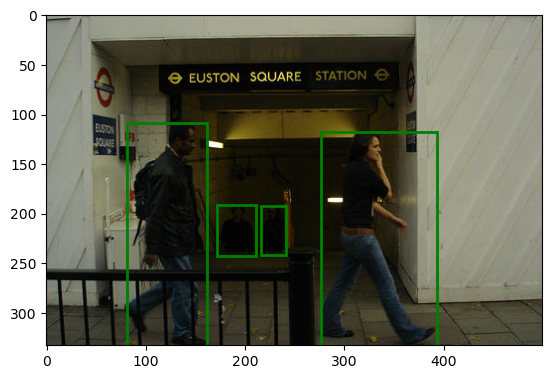

In [8]:
idx = torch.randint(low=0, high=len(val_data), size=(1,))

print(f"IDX: {idx.item()}\n")
image, gt_bbox, gt_class, gt_attributes, pred_attr, pred_score_attr = inference(idx=idx)
plot_inference(image, gt_bbox, gt_class, gt_attributes, pred_attr, pred_score_attr)